### Import Some Stuff

In [303]:
import os.path 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from statistics import pstdev
from scipy.fft import fftshift, ifft, fftfreq
import numpy as np
from scipy.signal.windows import tukey
import math
from scipy.interpolate import interp1d
from time import time as time
from time import strftime
from datetime import date
from scipy.signal import ShortTimeFFT
from scipy.signal import find_peaks, peak_widths
from scipy.stats import norm
from IPython.display import display, Latex
import re 
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import hilbert
from matplotlib.patches import Rectangle
from scipy.signal import savgol_filter

import lmfit

from scipy.signal.windows import tukey

plt.rcParams.update({'font.size':13})

# SHG-FROG Temporal Width Recovery 

## El Functions

In [497]:
def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset
def linear_func(x,m,c):
    return m*x +c

def quad_func(x,a,b,c):
    return a*x**2 + b*x +c 


def sech_squared(x,a,b,c):
    return a*(1/np.cosh(b*x))+c

def FROG_trace_folder(folder_path,save_folder_path, Relationship = None):

    temporal_widths_gauss =[]
    temporal_widths_sech =[]
    GDDs=[]
    
    folder = os.listdir(folder_path)
    

    for x in range(len(folder)):
        file_path = os.path.join(folder_path, folder[x])
        print('I am computing file',folder[x])
        #print(folder[x].split('_')[2])
        GDD = int(folder[x].split('_')[2])
        GDDs.append(GDD)
        #print(GDD)

        




        loaded_file = np.loadtxt(file_path)

        time = loaded_file[:,0]
        amplitude = loaded_file[:,1]


        analytic_signal = hilbert(amplitude)
        envelope = np.abs(analytic_signal)


        halfwidth =int(len(amplitude)/2)

        print(halfwidth)

        N = len(amplitude)
        center = N // 2
        

        start = center - halfwidth
        end = center + halfwidth
        signal_center = amplitude[start:end]
        envelope_center = envelope[start:end]
        time_center = time[start:end]


        peaks,peak_heights = find_peaks(signal_center,distance =10,prominence= 1e4)
        
        #print(len(peaks))

        A0= 2000*np.max(envelope_center)
        mu0 = time_center[np.argmax(envelope_center)]
        sigma0 = (time_center[-1] - time_center[0]) / 10
        offset0 = np.min(envelope_center)
        p0 = [A0, mu0, sigma0, offset0]
        

        params,params_covariance = curve_fit(gaussian, time_center[peaks], signal_center[peaks], p0=p0,maxfev =1000)
        params1,params_covariance1 = curve_fit(sech_squared, time_center[peaks], signal_center[peaks], p0=[A0,0.1,1])

        envelope_fit = (gaussian(time_center,(params[0]),params[1],params[2],params[3]))/np.max(gaussian(time_center,(params[0]),params[1],params[2],params[3]))
        envelope_fit_sech = (sech_squared(time_center,params1[0],params1[1],params1[2]))/np.max(sech_squared(time_center,params1[0],params1[1],params1[2]))
        time_fit = time_center[peaks]

        envelope_fit = envelope_fit - envelope_fit[0]
        envelope_fit_sech = envelope_fit_sech - envelope_fit_sech[0]


        fwhm = FWHM_2(time_center,envelope_fit)
        fwhm_2 = FWHM_2(time_center, envelope_fit_sech)

        #FROG_FWHM = fwhm/(np.sqrt(2))
        FROG_FWHM = fwhm*0.648
        #FROG_FWHM_2 = fwhm_2/(np.sqrt(2))
        FROG_FWHM_2 = fwhm_2*0.648
        temporal_widths_gauss.append(FROG_FWHM)
        temporal_widths_sech.append(FROG_FWHM_2)

        print('The estimated TL temporal width based on the above manipulation is {0:.3f}fs'.format(FROG_FWHM))

        plt.figure(figsize=(15,8))
        plt.plot(time, amplitude, color ='magenta', label = 'SHG-FROG 1d Trace')
        plt.plot(time_center,gaussian(time_center,(params[0]),params[1],params[2],params[3]), color='darkblue', label ='Gaussian Fit to FROG peaks, Temp. Width ={0:.3f}fs'.format(FROG_FWHM))
        plt.scatter(time_center[peaks], signal_center[peaks], color='red', label = 'SHG FROG Local Max')
        plt.plot(time_center,sech_squared(time_center,params1[0],params1[1],params1[2]), color='darkorange', label ='$Sech^2$ Fit to FROG peaks, Temp. Width ={0:.3f}fs'.format(FROG_FWHM_2))
        plt.xlabel("Time (fS))")
        plt.ylabel("Arb. Intensity")
        plt.legend()
        title = 'FROG_trace_fit_GDD_'+str(GDD)+'.png'
        save_folder =os.path.join(save_folder_path,title)
        plt.title('FROG Trace Fit for GDD='+str(GDD)+'')
        plt.savefig(save_folder)
        plt.show()

    if Relationship == True: 
    
        if len(GDDs) >1: 
            params, params_covariance = curve_fit(linear_func, GDDs, temporal_widths_gauss, p0=[1,0],maxfev =1000)
            #params1, params_covariance2 = curve_fit(quad_func,GDDs,temporal_widths_gauss, p0 =[1,0,0], maxfev= 1000)
            params2, params_covariance2 = curve_fit(linear_func, GDDs, temporal_widths_sech, p0=[1,0],maxfev =1000)

        print(GDDs)
        GDDs =np.array(GDDs)

        plt.figure(figsize=(15,8))
        plt.scatter(GDDs, temporal_widths_gauss, color ='red', label = 'FROG Recovered Data Points')
        plt.scatter(GDDs, temporal_widths_sech, color ='blue', label = 'FROG Recovered Data Points')
        if len(GDDs) >1 :
            plt.plot(GDDs,linear_func(GDDs, params2[0], params2[1]), color ='blue', label = '$sech^2$ LOBF => y= {0:.3f}x + {1:.3f}'.format(params2[0],params2[1]))
            plt.plot(GDDs,linear_func(GDDs, params[0], params[1]), color ='red', label = 'Guassian LOBF => y= {0:.3f}x + {1:.3f}'.format(params[0],params[1]))
        #plt.plot(GDDs,quad_func(GDDs,*params1), color ='red', label ='Quadratic LOBF')
        plt.xlabel("Software Applied GDD ($fs^2$)")
        plt.ylabel("Temporal Width (fs)")
        plt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")
        title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
        save_folder =os.path.join(save_folder_path,title)
        
        plt.savefig(save_folder)
        plt.legend()
        plt.show()

def FROG_trace(file, GDD):

    loaded_file = np.loadtxt(file)

    time = loaded_file[:,0]
    amplitude = loaded_file[:,1]


    analytic_signal = hilbert(amplitude)
    envelope = np.abs(analytic_signal)
    



    N = len(amplitude)
    center = N // 2
    halfwidth = len(amplitude)/2  # 100 total points = 50 on each side

    start = center - halfwidth
    end = center + halfwidth
    signal_center = amplitude[start:end]
    envelope_center = envelope[start:end]
    time_center = time[start:end]

    peaks,peak_heights = find_peaks(signal_center,distance =10,prominence= 1e4)

    #print(len(peaks))

    A0= 2000*np.max(envelope_center)
    mu0 = time_center[np.argmax(envelope_center)]
    sigma0 = (time_center[-1] - time_center[0]) / 10
    offset0 = np.min(envelope_center)
    p0 = [A0, mu0, sigma0, offset0]


    params,params_covariance = curve_fit(gaussian, time_center[peaks], signal_center[peaks], p0=p0,maxfev =1000)

    envelope_fit = (gaussian(time_center,(params[0]),params[1],params[2],params[3]))/np.max(gaussian(time_center,(params[0]),params[1],params[2],params[3]))
    time_fit = time_center[peaks]

    envelope_fit = envelope_fit - envelope_fit[0]


    fwhm = FWHM_2(time_center,envelope_fit)

    FROG_FWHM = fwhm/2


    print('The estimated TL temporal width based on the above manipulation is {0:.3f}fs'.format(FROG_FWHM))

    plt.figure(figsize=(15,8))
    plt.plot(time, amplitude, color ='magenta', label = 'TL SHG-FROG 1d Trace')
    plt.plot(time_center,gaussian(time_center,(params[0]),params[1],params[2],params[3]), color='darkblue', label ='Gaussian Fit to FROG peaks, Temp. Width ={0:.3f}fs'.format(FROG_FWHM))
    plt.scatter(time_center[peaks], signal_center[peaks], color='red', label = 'SHG FROG Local Max')
    plt.xlabel("Time (fS))")
    plt.ylabel("Arb. Intensity")
    plt.legend()
    title = 'FROG_trace_fit_GDD_'+str(GDD)+'.png'
    plt.title('FROG Trace Fit for GDD='+str(GDD)+'')
    plt.savefig(title)
    plt.show()
    
    
    return FROG_FWHM

def FWHM_2(x,y):
    peak =np.argmax(y)
    peak_val =y[peak]
    half_max = peak_val /2 
    

    # Left side
    left_region = y[:peak]
    if np.any(left_region <= half_max):
        y1 = np.where(left_region <= half_max)[0][-1]
        y0 = y1 + 1
        # linear interpolation for crossing
        x_left = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    #else:
        #return np.nan
    
    # Right side
    right_region = y[peak:]
    if np.any(right_region <= half_max):
        y1 = np.where(right_region <= half_max)[0][0] + peak
        y0 = y1 - 1
        x_right = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    #else:
        #return np.nan
    
    fwhm = x_right -x_left
    return fwhm


## Load The Data File

In [368]:
file_path = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/211125/1D_FROG/21125_GDD_330_FROG_801_0.75_6ms_1d.txt'
applied_GDD = 330
save_name = 'an_attempt_at_a_fit_GDD_'+str(applied_GDD)+'.txt'

## Apply The Function

The estimated TL temporal width based on the above manipulation is 54.031fs


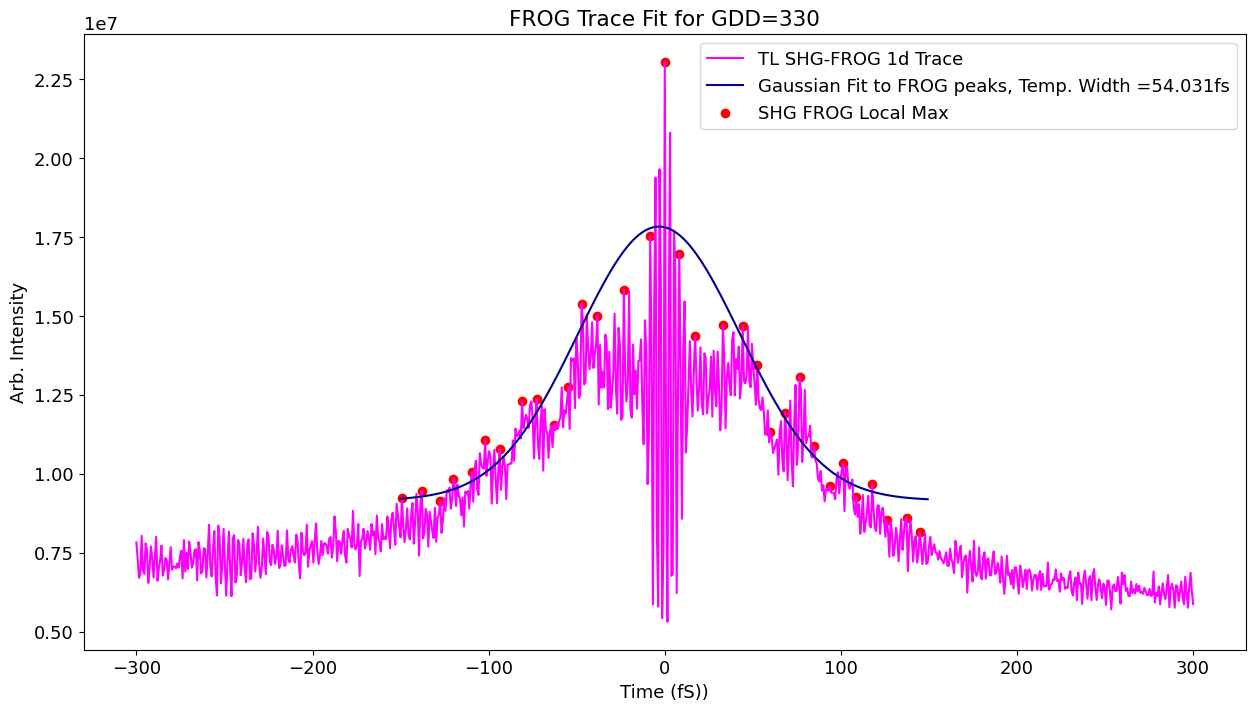

In [285]:
#FWHM_time = FROG_trace(file_path, applied_GDD)

## Load the Data Folder 

In [403]:
folder = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/211125/1D_FROG/'
save_folder_path = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/211125/'



## Apply the Folder Function 

I am computing file 21125_GDD_330_FROG_801_0.75_6ms_1d.txt
400
The estimated TL temporal width based on the above manipulation is 91.286fs


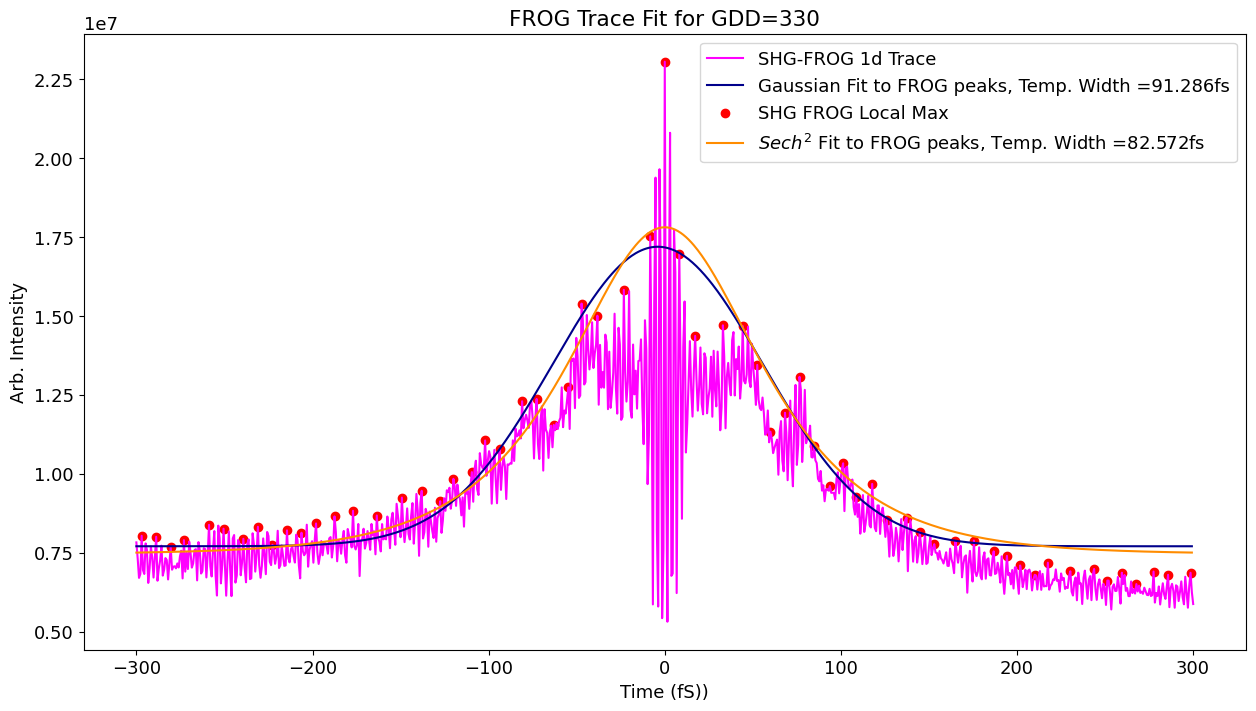

I am computing file 211125_GDD_3321_FROG_801_0.75_1d.txt
400
The estimated TL temporal width based on the above manipulation is 18.713fs


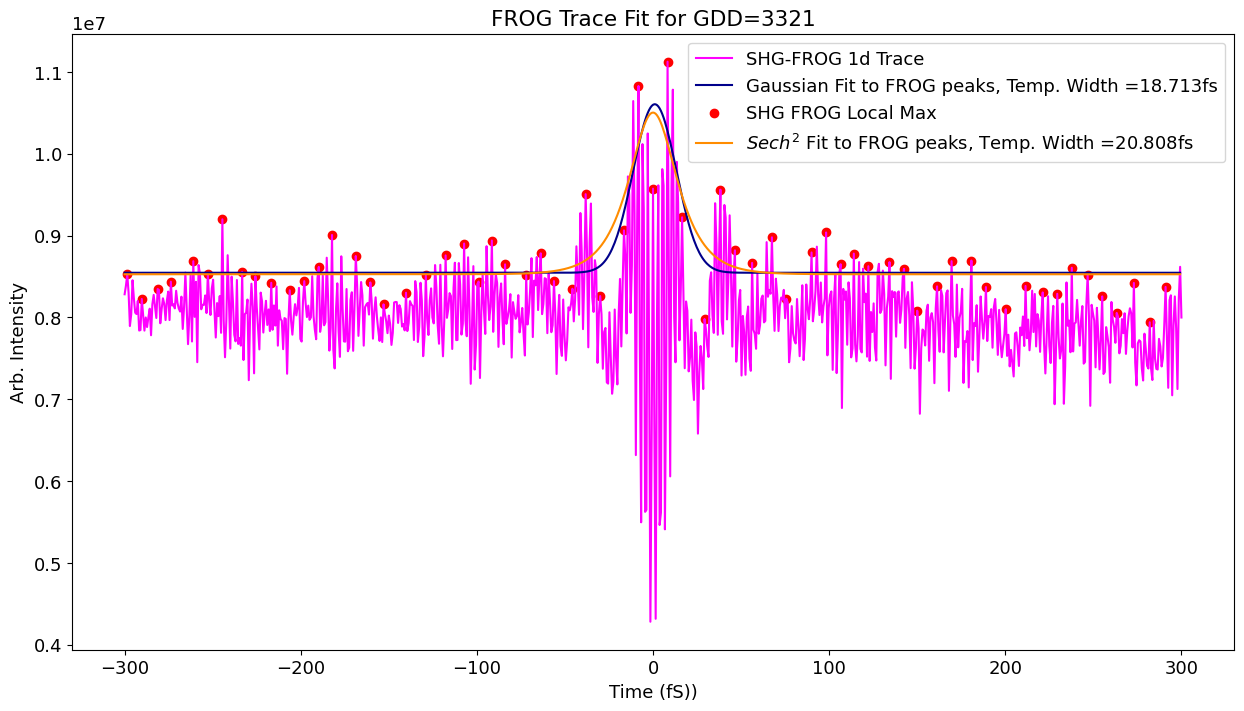

I am computing file 211125_GDD_4484_FROG_801_1_1d.txt
400
The estimated TL temporal width based on the above manipulation is 45.540fs


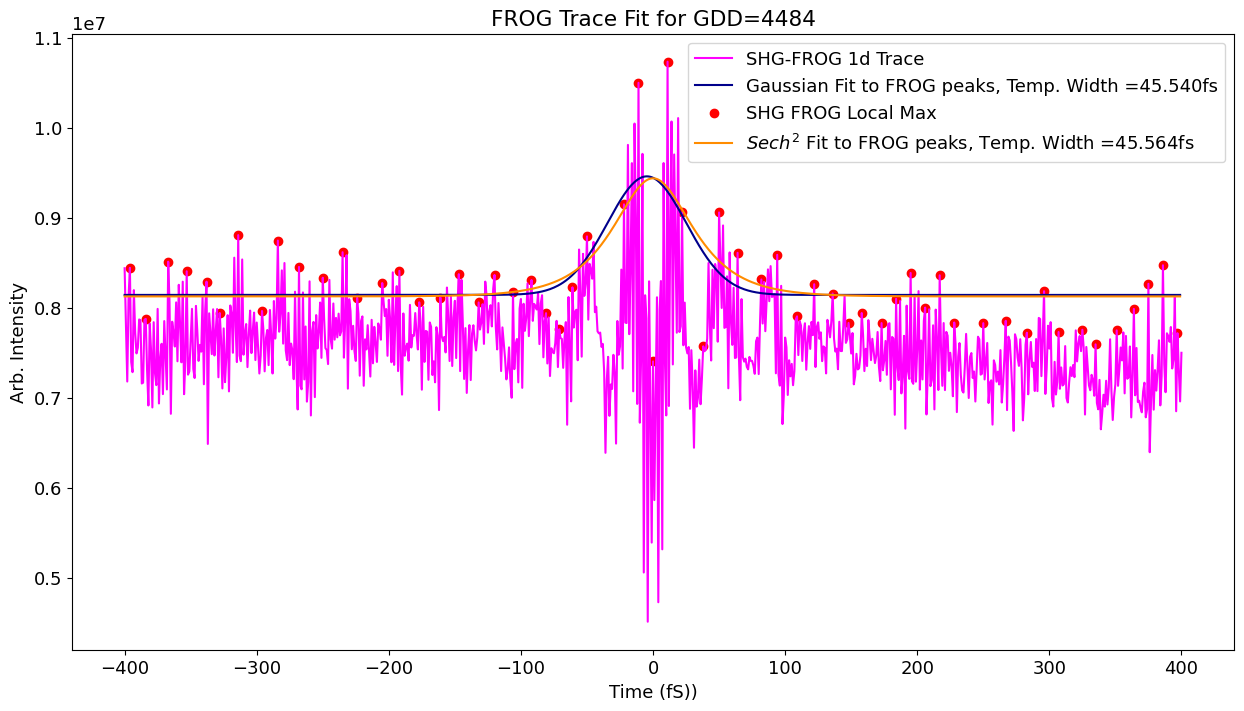

I am computing file 21125_GDD_330_FROG_801_0.75_4ms_1d.txt
400
The estimated TL temporal width based on the above manipulation is 68.096fs


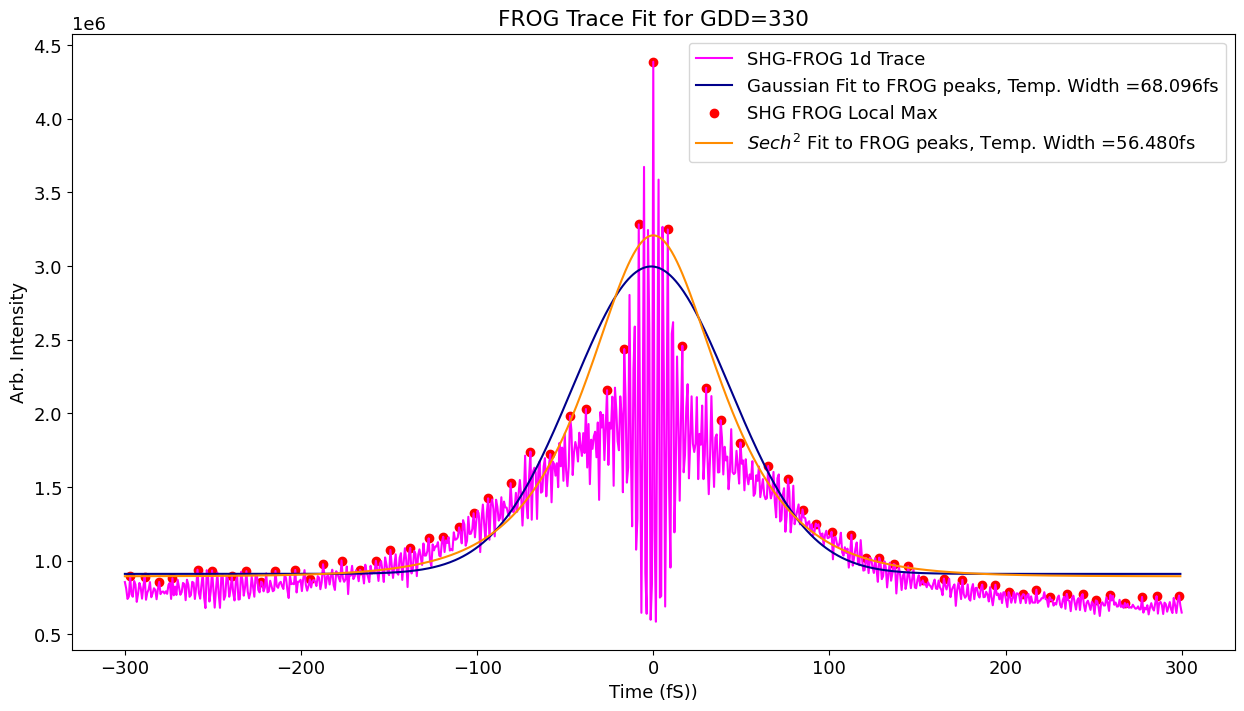

[330, 3321, 4484, 330]


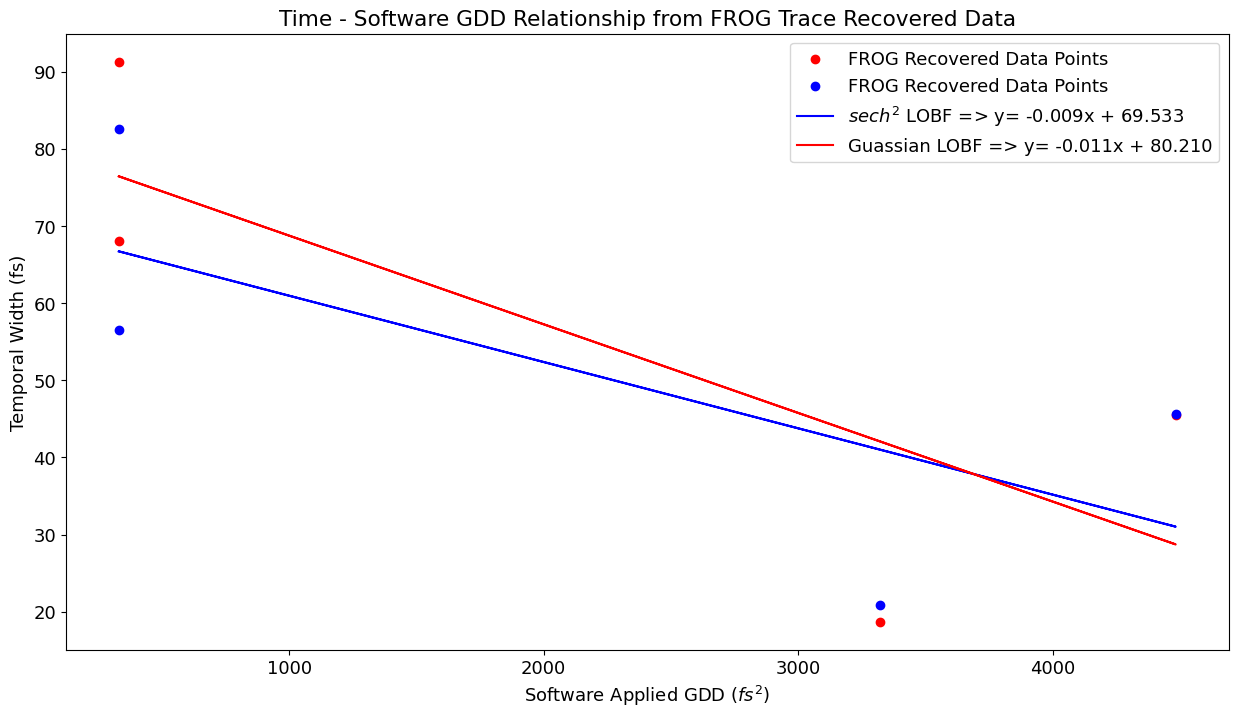

In [498]:
FROG_trace_folder(folder,save_folder_path, Relationship= True)

In [437]:
file_4484 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125/251125_GDD_4484_6001_1_1d.txt'
loaded_file_4484 = np.loadtxt(file_4484)

time_4484 = loaded_file_4484[:,0]
amplitude_4484 = loaded_file_4484[:,1]

start = 1000
end =5001
amplitude_4484_crop = amplitude_4484[start:end]
print(len(amplitude_4484_crop))
time_4484_crop = time_4484[start:end]


4001


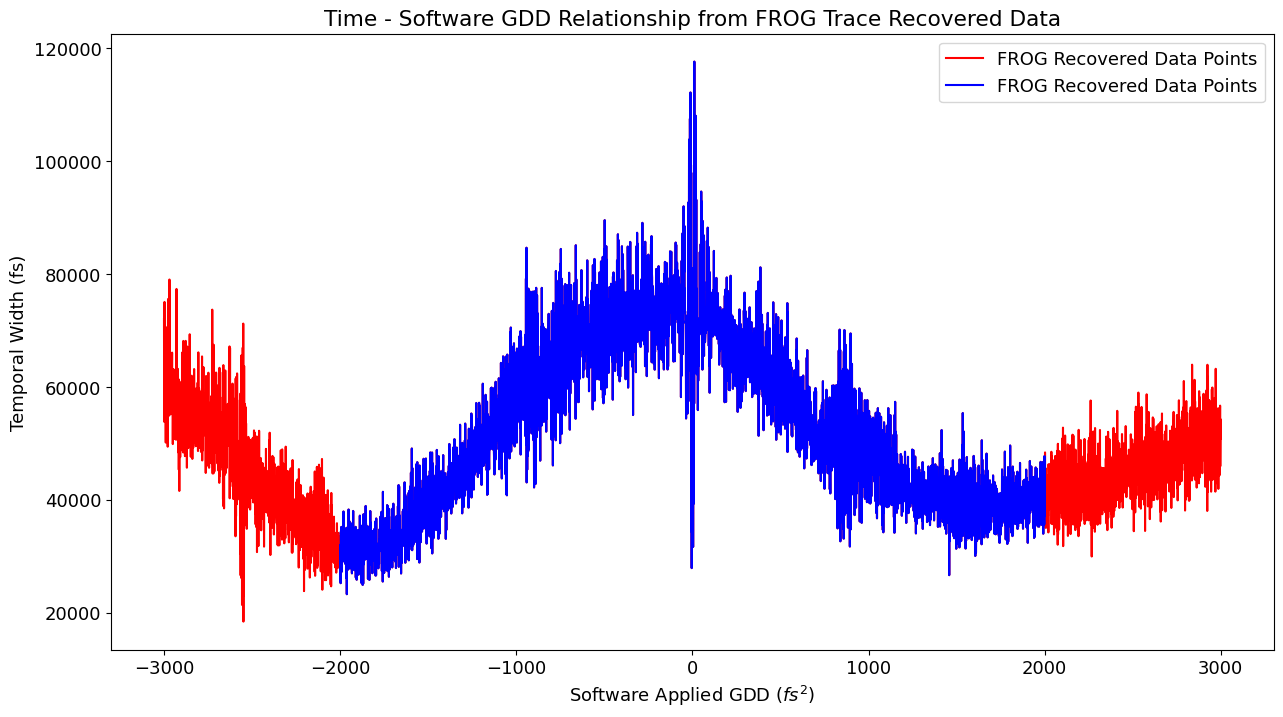

In [439]:
plt.figure(figsize=(15,8))
plt.plot(time_4484, amplitude_4484, color ='red', label = 'FROG Recovered Data Points')
plt.plot(time_4484_crop, amplitude_4484_crop, color ='blue', label = 'FROG Recovered Data Points')
plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
#save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()



In [440]:
np.savetxt('251125_GDD_4484_cropped.txt', np.c_[time_4484_crop, amplitude_4484_crop],delimiter='\t')

In [465]:
file_3321 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125/251125_GDD_3321_6001_1_1d.txt'
loaded_file_3321 = np.loadtxt(file_3321)

time_3321 = loaded_file_3321[:,0]
amplitude_3321 = loaded_file_3321[:,1]

start = 1900
end =4501
amplitude_3321_crop = amplitude_3321[start:end]
print(len(amplitude_3321_crop))
time_3321_crop = time_3321[start:end]

2601


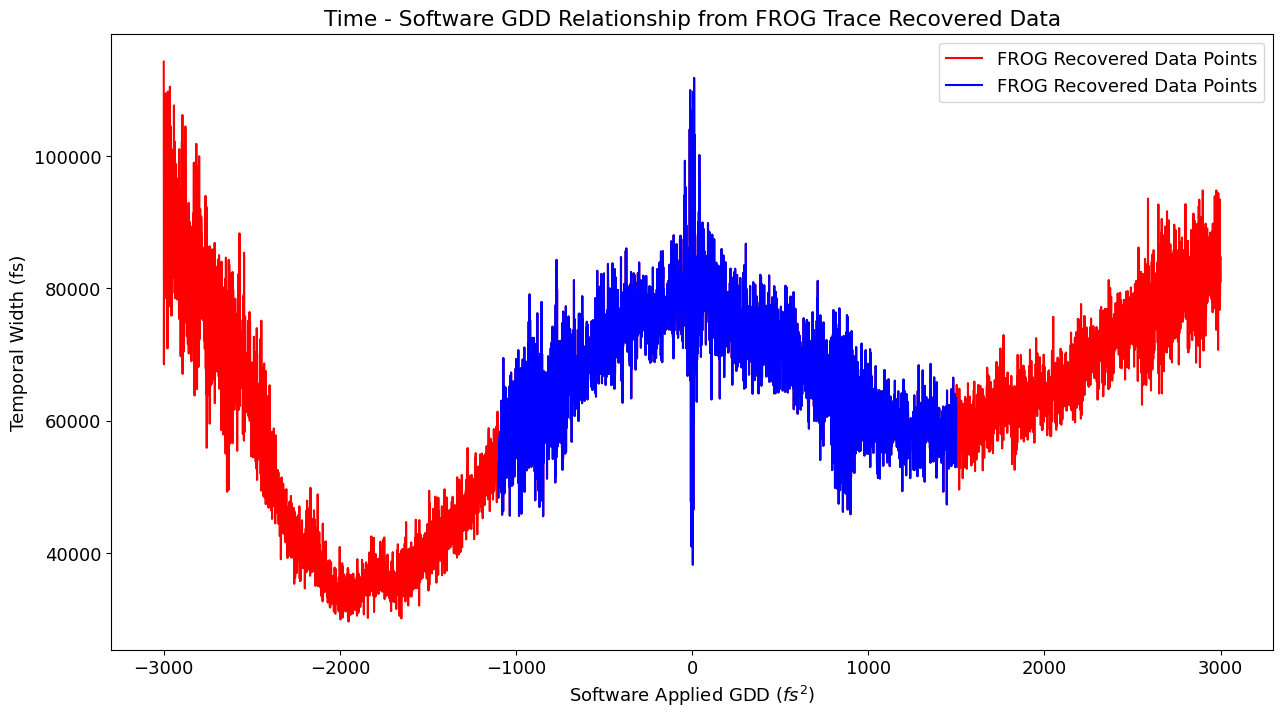

In [466]:
plt.figure(figsize=(15,8))
plt.plot(time_3321, amplitude_3321, color ='red', label = 'FROG Recovered Data Points')
plt.plot(time_3321_crop, amplitude_3321_crop, color ='blue', label = 'FROG Recovered Data Points')
plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
#save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()

In [467]:
np.savetxt('251125_GDD_3321_cropped.txt', np.c_[time_3321_crop, amplitude_3321_crop],delimiter='\t')

In [483]:
file_700 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125/251125_GDD_700_3001_1_1d.txt'
loaded_file_700 = np.loadtxt(file_700)

time_700 = loaded_file_700[:,0]
amplitude_700 = loaded_file_700[:,1]

start = 1100
end =1800
amplitude_700_crop = amplitude_700[start:end]
print(len(amplitude_700_crop))
time_700_crop = time_700[start:end]

700


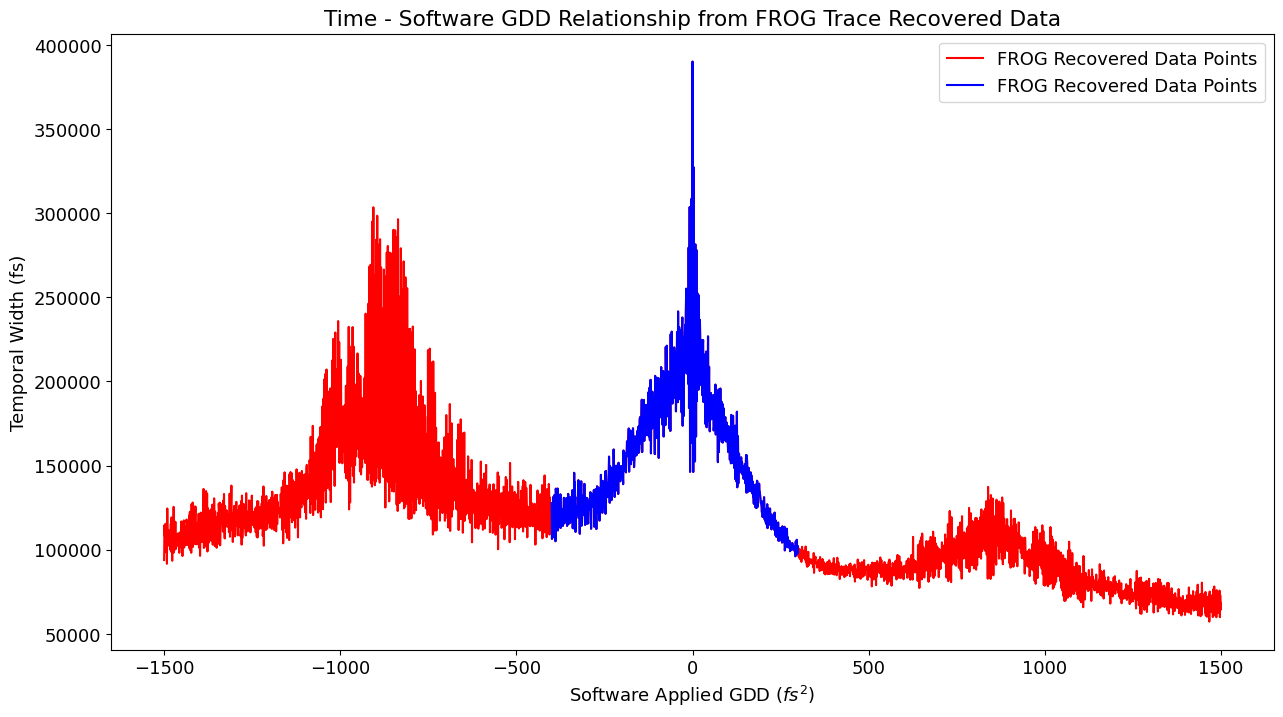

In [484]:
plt.figure(figsize=(15,8))
plt.plot(time_700, amplitude_700, color ='red', label = 'FROG Recovered Data Points')
plt.plot(time_700_crop, amplitude_700_crop, color ='blue', label = 'FROG Recovered Data Points')
plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
#save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()

In [485]:
np.savetxt('251125_GDD_700_cropped.txt', np.c_[time_700_crop, amplitude_700_crop],delimiter='\t')

I am computing file 251125_GDD_700_cropped.txt
350
The estimated TL temporal width based on the above manipulation is 120.310fs


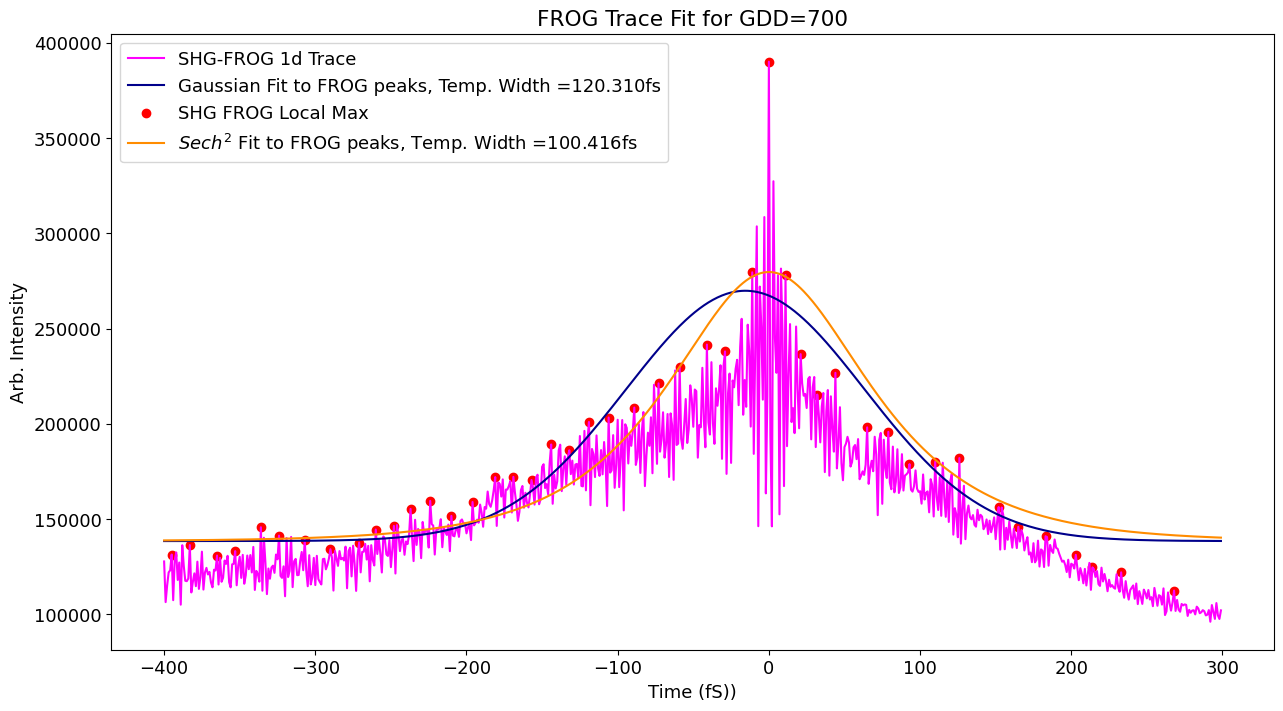

In [499]:
folder_2= r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/251125_2/'
save_folder_path_2 = r'/Users/craigpaterson/Library/CloudStorage/OneDrive-UniversityofGlasgow/5th Year/Project Data/Results/251125/'


FROG_trace_folder(folder_2,save_folder_path_2, Relationship= False)

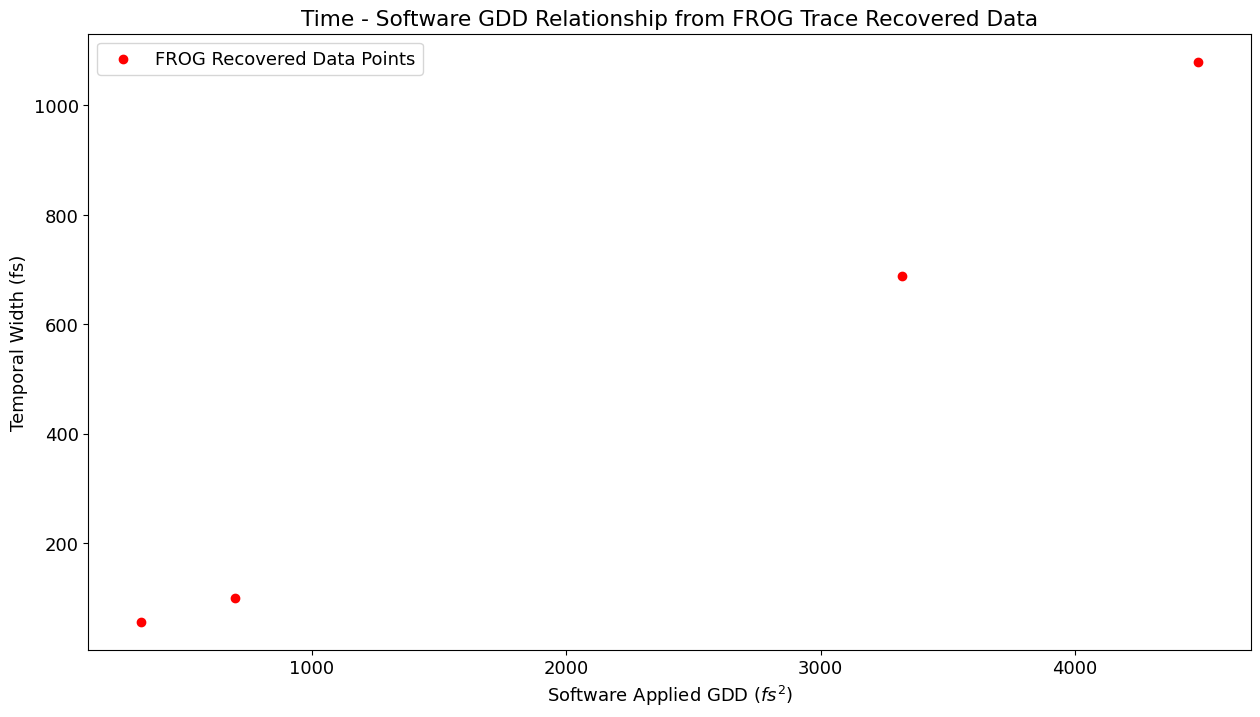

In [492]:

gdd =[330,700,3321,4484]

sech_fwhm =[56.483,100.416,688.5,1080]

plt.figure(figsize=(15,8))
plt.scatter(gdd, sech_fwhm, color ='red', label = 'FROG Recovered Data Points')

plt.xlabel("Software Applied GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("Time - Software GDD Relationship from FROG Trace Recovered Data")
title = 'Time_GDD_Relationship_GDD_recovered_'+(date.today()).strftime("_%d_%m_%y")+'.png'
#save_folder =os.path.join(save_folder_path,title)

#plt.savefig(save_folder)
plt.legend()
plt.show()